# Klasifikace obrázků oblečení pomocí neuronových sítí

Dataset jsou 32x32 obrázky, které vznikly úpravou obrázků z tohoto [datasetu](https://www.kaggle.com/datasets/zalando-research/fashionmnist). Příznaky jsou jednotlivé pixely a **label**.

Dataset si připravím a pak provedu klasifikaci pomocí dopředných a konvolučních neuronových sítí. Budu experimentovat s hloubkou a šířkou sítí, s různými metodami regularizace a vyzkouším i různé optimizery.

Soubor `train.csv` nahraný na GitHub je z důvodu velké velikosti menší než soubor použitý k trénování.

In [1]:
import math
import warnings
import itertools
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import torch
import torchvision
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tqdm import tqdm
from joblib import Parallel, delayed
%matplotlib inline

# Příprava dat

Data načtu a rozdělím na trénovací, validační a testovací množinu v poměru 6:2:2.

In [2]:
data = pd.read_csv("train.csv")
display(data.head())
data.info()
data["label"].unique()

,pix1,pix2,pix3,pix4,pix5,pix6,pix7,pix8,pix9,pix10,...,pix1016,pix1017,pix1018,pix1019,pix1020,pix1021,pix1022,pix1023,pix1024,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
1,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,0
2,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,6
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
4,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52500 entries, 0 to 52499
Columns: 1025 entries, pix1 to label
dtypes: int64(1025)
memory usage: 410.6 MB


array([7, 0, 6, 3, 4, 8, 1, 9, 2, 5])

Připravím si čtyři datasety:

- původní hodnoty
- hodnoty vydělené 255
- min-max normalizace po pixelech
- standardizace po pixelech

In [5]:
Xdata = data.drop("label", axis=1)
Ydata = data["label"]

random_seed = 333

Xtrain, Xrest, Ytrain, Yrest = train_test_split(Xdata, Ydata, test_size=0.4, random_state=random_seed)
Xval, Xtest, Yval, Ytest = train_test_split(Xrest, Yrest, test_size=0.5, random_state=random_seed)

train_data = torch.utils.data.TensorDataset(torch.tensor(Xtrain.to_numpy().reshape(-1, 1, 32, 32), dtype=torch.float), torch.tensor(Ytrain.to_numpy(), dtype=torch.long))
val_data = torch.utils.data.TensorDataset(torch.tensor(Xval.to_numpy().reshape(-1, 1, 32, 32), dtype=torch.float), torch.tensor(Yval.to_numpy(), dtype=torch.long))
test_data = torch.utils.data.TensorDataset(torch.tensor(Xtest.to_numpy().reshape(-1, 1, 32, 32), dtype=torch.float), torch.tensor(Ytest.to_numpy(), dtype=torch.long))
datasets_default = (train_data, val_data, test_data)

In [7]:
Xtrain_normal = Xtrain.copy()
Xval_normal = Xval.copy()
Xtest_normal = Xtest.copy()
Xtrain_normal /= 255.0
Xval_normal /= 255.0
Xtest_normal /= 255.0

train_data_normal = torch.utils.data.TensorDataset(torch.tensor(Xtrain_normal.to_numpy().reshape(-1, 1, 32, 32), dtype=torch.float), torch.tensor(Ytrain.to_numpy(), dtype=torch.long))
val_data_normal = torch.utils.data.TensorDataset(torch.tensor(Xval_normal.to_numpy().reshape(-1, 1, 32, 32), dtype=torch.float), torch.tensor(Yval.to_numpy(), dtype=torch.long))
test_data_normal = torch.utils.data.TensorDataset(torch.tensor(Xtest_normal.to_numpy().reshape(-1, 1, 32, 32), dtype=torch.float), torch.tensor(Ytest.to_numpy(), dtype=torch.long))
datasets_normal = (train_data_normal, val_data_normal, test_data_normal)

In [8]:
scaler_minmax = MinMaxScaler()
Xtrain_minmax = Xtrain.copy()
Xval_minmax = Xval.copy()
Xtest_minmax = Xtest.copy()
Xtrain_minmax = scaler_minmax.fit_transform(Xtrain_minmax)
Xval_minmax = scaler_minmax.transform(Xval_minmax)
Xtest_minmax = scaler_minmax.transform(Xtest_minmax)

train_data_minmax = torch.utils.data.TensorDataset(torch.tensor(Xtrain_minmax.reshape(-1, 1, 32, 32), dtype=torch.float), torch.tensor(Ytrain.to_numpy(), dtype=torch.long))
val_data_minmax = torch.utils.data.TensorDataset(torch.tensor(Xval_minmax.reshape(-1, 1, 32, 32), dtype=torch.float), torch.tensor(Yval.to_numpy(), dtype=torch.long))
test_data_minmax = torch.utils.data.TensorDataset(torch.tensor(Xtest_minmax.reshape(-1, 1, 32, 32), dtype=torch.float), torch.tensor(Ytest.to_numpy(), dtype=torch.long))
datasets_minmax = (train_data_minmax, val_data_minmax, test_data_minmax)

In [9]:
scaler_std = StandardScaler()
Xtrain_std = Xtrain.copy()
Xval_std = Xval.copy()
Xtest_std = Xtest.copy()
Xtrain_std = scaler_std.fit_transform(Xtrain_std)
Xval_std = scaler_std.transform(Xval_std)
Xtest_std = scaler_std.transform(Xtest_std)

train_data_std = torch.utils.data.TensorDataset(torch.tensor(Xtrain_std.reshape(-1, 1, 32, 32), dtype=torch.float), torch.tensor(Ytrain.to_numpy(), dtype=torch.long))
val_data_std = torch.utils.data.TensorDataset(torch.tensor(Xval_std.reshape(-1, 1, 32, 32), dtype=torch.float), torch.tensor(Yval.to_numpy(), dtype=torch.long))
test_data_std = torch.utils.data.TensorDataset(torch.tensor(Xtest_std.reshape(-1, 1, 32, 32), dtype=torch.float), torch.tensor(Ytest.to_numpy(), dtype=torch.long))
datasets_std = (train_data_std, val_data_std, test_data_std)

In [11]:
display(Xtrain.head())
display(Xtrain.info())
display(Xtrain.describe())
display(Ytrain.value_counts())

,pix1,pix2,pix3,pix4,pix5,pix6,pix7,pix8,pix9,pix10,...,pix1015,pix1016,pix1017,pix1018,pix1019,pix1020,pix1021,pix1022,pix1023,pix1024
8958,0,0,0,0,0,0,0,0,0,0,...,58,52,34,0,0,0,0,0,0,0
43710,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20678,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2490,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34044,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


<class 'pandas.core.frame.DataFrame'>
Index: 31500 entries, 8958 to 8172
Columns: 1024 entries, pix1 to pix1024
dtypes: int64(1024)
memory usage: 246.3 MB


None

,pix1,pix2,pix3,pix4,pix5,pix6,pix7,pix8,pix9,pix10,...,pix1015,pix1016,pix1017,pix1018,pix1019,pix1020,pix1021,pix1022,pix1023,pix1024
count,31500.000000,31500.000000,31500.000000,31500.000000,31500.000000,31500.000000,31500.000000,31500.000000,31500.000000,31500.000000,...,31500.000000,31500.000000,31500.000000,31500.000000,31500.000000,31500.000000,31500.000000,31500.000000,31500.000000,31500.000000
mean,0.887175,0.887175,0.887175,0.887175,0.887175,0.887270,0.887270,0.887524,0.888889,0.892159,...,0.907079,0.905429,0.908508,0.901175,0.891365,0.887619,0.887238,0.887206,0.887175,0.887175
std,1.507413,1.507413,1.507413,1.507413,1.507413,1.507557,1.507473,1.508124,1.515794,1.564417,...,1.918372,1.669065,1.843218,1.716884,1.530604,1.508331,1.507523,1.507447,1.507413,1.507413
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,27.000000,66.000000,...,151.000000,77.000000,101.000000,83.000000,35.000000,11.000000,11.000000,11.000000,11.000000,11.000000


label
8    3191
0    3189
9    3188
2    3187
4    3175
3    3165
7    3118
1    3109
6    3108
5    3070
Name: count, dtype: int64

Vidíme, že první pixely (horní okraj) nabývají jen hodnot 0-11, jde o tmavé pozadí obrázků. Dataset je vyvážený, jde o klasifikaci do deseti tříd. Na nějaké obrázky se podívejme.

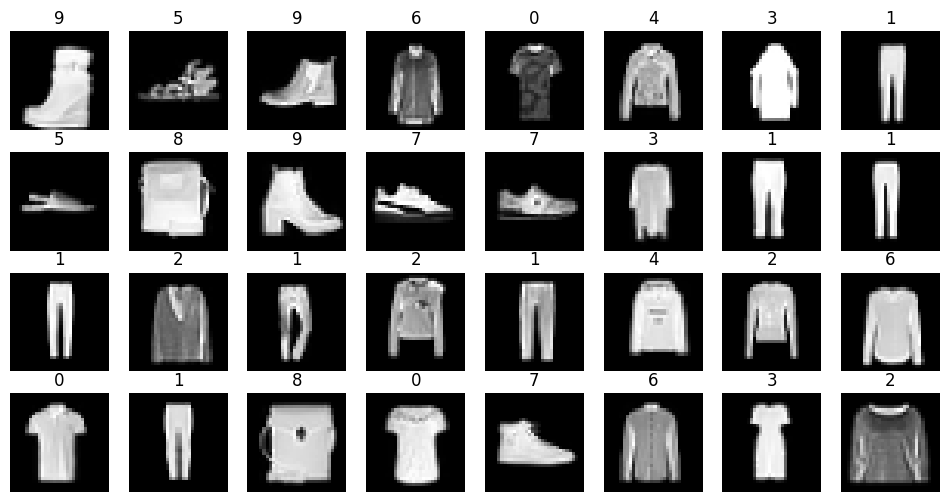

In [12]:
fig, axes = plt.subplots(4, 8, figsize=(12, 6))

for i, ax in enumerate(axes.flatten()):
    ax.axis(False)
    ax.imshow(Xtrain.iloc[i].to_numpy().reshape(32, 32), cmap="gray")
    ax.set_title(f"{Ytrain.iloc[i]}")

Jednotlivé třídy jsou:

- 0 - trička
- 1 - kalhoty
- 2 - svetry
- 3 - šaty
- 4 - kabáty
- 5 - sandály
- 6 - košile
- 7 - tenisky
- 8 - tašky
- 9 - kotníkové boty

# Dopředná neuronová síť

Tento model není nejvhodnější pro zpracování obrázků, protože nezohledňuje prostorovou strukturu. Přesto nemusí dávat úplně špatné výsledky.

Nejprve si připravím funkce pro trénování. Kvalitu modelu budu soudit podle validační přesnosti kvůli poslední části úkolu (body za přesnost).

In [13]:
def get_loaders(datasets, train_batch_size):
    train_loader = torch.utils.data.DataLoader(datasets[0], batch_size=train_batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(datasets[1], batch_size=128, shuffle=False)
    test_loader = torch.utils.data.DataLoader(datasets[2], batch_size=128, shuffle=False)
    return (train_loader, val_loader, test_loader)

def train_one_epoch(model, loss_fn, optimizer, training_loader):
    running_cum_loss = 0.
    for data in tqdm(training_loader, total=len(training_loader)):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        last_mean_loss = loss.item()
        running_cum_loss += last_mean_loss * inputs.shape[0]
    return running_cum_loss / len(train_data)

def train_multiple_epochs(epochs_max, epochs_patience, model, loss_fn, optimizer, training_loader, validation_loader, model_path):
    best_acc = 0.0
    epochs_from_best = 0
    for epoch in range(epochs_max):
        print(f"EPOCH {epoch + 1}:")
    
        model.train(True)
        avg_loss = train_one_epoch(model, loss_fn, optimizer, training_loader)
        model.train(False)
        
        running_cum_vloss = 0.0
        vcorrect = 0
        for vdata in validation_loader:
            vinputs, vlabels = vdata
            with torch.no_grad():
                voutputs = model(vinputs)
                vloss = loss_fn(voutputs, vlabels)
            running_cum_vloss += vloss * vinputs.shape[0]
            vcorrect += (voutputs.argmax(1) == vlabels).float().sum()
        avg_vloss = running_cum_vloss / len(val_data)
        vacc = vcorrect / len(val_data)
        
        print(f"TRAIN loss: {avg_loss:.3f}, VALIDATION loss: {avg_vloss:.3f}, accuracy: {vacc:.3f}")

        if vacc > best_acc:
            print("Saving best model")
            best_acc = vacc
            torch.save(model.state_dict(), model_path)
            epochs_from_best = 0
        else:
            print("No improvement")
            epochs_from_best += 1

        if epochs_from_best >= epochs_patience:
            print("Early stopping")
            break

Vyzkouším tři neuronové sítě s různým počtem vrstev a počtem neuronů. Jako aktivační funkci skrytých vrstev použiju RELU.

In [14]:
class NeuralNetwork1(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32 * 32, 256)
        self.fc2 = nn.Linear(256, 16)
        self.fco = nn.Linear(16, 10)

    def forward(self, x):
        x = x.flatten(start_dim = 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fco(x)
        return x

class NeuralNetwork2(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32 * 32, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fco = nn.Linear(16, 10)

    def forward(self, x):
        x = x.flatten(start_dim = 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fco(x)
        return x

class NeuralNetwork3(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32 * 32, 2048)
        self.fco = nn.Linear(2048, 10)

    def forward(self, x):
        x = x.flatten(start_dim = 1)
        x = F.relu(self.fc1(x))
        x = self.fco(x)
        return x

Pojďme si nějaké sítě natrénovat. Některé trénovací buňky budu pouštět vícekrát, tedy ne vždy je desátá epocha skutečně desátá, ale může být třeba třicátá.

## Šířka, hloubka

Nejprve natrénuji střední síť (2 skryté vrstvy).

In [15]:
model = NeuralNetwork1()
train_loader, val_loader, test_loader = get_loaders(datasets_normal, 32)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
epochs = 10
patience = 4

In [17]:
train_multiple_epochs(epochs, patience, model, loss_fn, optimizer, train_loader, val_loader, "saves/A01.pt")

EPOCH 1:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:01<00:00, 535.23it/s]


TRAIN loss: 0.353, VALIDATION loss: 0.464, accuracy: 0.828
Saving best model
EPOCH 2:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:01<00:00, 568.62it/s]


TRAIN loss: 0.339, VALIDATION loss: 0.435, accuracy: 0.845
Saving best model
EPOCH 3:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:01<00:00, 566.43it/s]


TRAIN loss: 0.329, VALIDATION loss: 0.455, accuracy: 0.838
No improvement
EPOCH 4:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:01<00:00, 568.60it/s]


TRAIN loss: 0.319, VALIDATION loss: 0.474, accuracy: 0.831
No improvement
EPOCH 5:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:01<00:00, 560.41it/s]


TRAIN loss: 0.309, VALIDATION loss: 0.442, accuracy: 0.845
No improvement
EPOCH 6:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:01<00:00, 562.39it/s]


TRAIN loss: 0.299, VALIDATION loss: 0.452, accuracy: 0.843
No improvement
Early stopping


Buňku jsem pustil dvakrát. Po dvanácti epochách dosáhla první síť (2 skryté vrstvy) přesnosti 84.5 %.

Podívejme se i na hlubší, ale tenčí síť (4 skryté vrstvy, méně neuronů).

In [18]:
model = NeuralNetwork2()
train_loader, val_loader, test_loader = get_loaders(datasets_normal, 32)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
epochs = 10
patience = 4

In [20]:
train_multiple_epochs(epochs, patience, model, loss_fn, optimizer, train_loader, val_loader, "saves/A02.pt")

EPOCH 1:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:01<00:00, 547.70it/s]


TRAIN loss: 0.392, VALIDATION loss: 0.488, accuracy: 0.822
Saving best model
EPOCH 2:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:01<00:00, 587.69it/s]


TRAIN loss: 0.379, VALIDATION loss: 0.447, accuracy: 0.837
Saving best model
EPOCH 3:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:01<00:00, 565.00it/s]


TRAIN loss: 0.366, VALIDATION loss: 0.454, accuracy: 0.832
No improvement
EPOCH 4:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:01<00:00, 566.25it/s]


TRAIN loss: 0.355, VALIDATION loss: 0.453, accuracy: 0.838
Saving best model
EPOCH 5:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:01<00:00, 566.12it/s]


TRAIN loss: 0.347, VALIDATION loss: 0.508, accuracy: 0.818
No improvement
EPOCH 6:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:01<00:00, 569.69it/s]


TRAIN loss: 0.338, VALIDATION loss: 0.452, accuracy: 0.839
Saving best model
EPOCH 7:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:01<00:00, 588.23it/s]


TRAIN loss: 0.328, VALIDATION loss: 0.440, accuracy: 0.841
Saving best model
EPOCH 8:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:01<00:00, 589.11it/s]


TRAIN loss: 0.320, VALIDATION loss: 0.460, accuracy: 0.841
No improvement
EPOCH 9:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:01<00:00, 564.32it/s]


TRAIN loss: 0.315, VALIDATION loss: 0.461, accuracy: 0.842
Saving best model
EPOCH 10:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:01<00:00, 556.44it/s]


TRAIN loss: 0.304, VALIDATION loss: 0.485, accuracy: 0.832
No improvement


Buňku jsem pustil dvakrát. Po devatenácti epochách síť dosáhla přesnosti 84.2 %, to je skoro stejné jako minulá síť, ale o trochu méně.

Nakonec vyzkouším síť s pouze jednou skrytou vrstvou, ale 2048 neurony.

In [21]:
model = NeuralNetwork3()
train_loader, val_loader, test_loader = get_loaders(datasets_normal, 32)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
epochs = 10
patience = 4

In [23]:
train_multiple_epochs(epochs, patience, model, loss_fn, optimizer, train_loader, val_loader, "saves/A03.pt")

EPOCH 1:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:08<00:00, 117.58it/s]


TRAIN loss: 0.296, VALIDATION loss: 0.441, accuracy: 0.851
Saving best model
EPOCH 2:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:08<00:00, 115.86it/s]


TRAIN loss: 0.287, VALIDATION loss: 0.436, accuracy: 0.851
Saving best model
EPOCH 3:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:08<00:00, 121.66it/s]


TRAIN loss: 0.275, VALIDATION loss: 0.459, accuracy: 0.849
No improvement
EPOCH 4:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:08<00:00, 117.09it/s]


TRAIN loss: 0.264, VALIDATION loss: 0.440, accuracy: 0.852
Saving best model
EPOCH 5:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:08<00:00, 118.07it/s]


TRAIN loss: 0.256, VALIDATION loss: 0.457, accuracy: 0.846
No improvement
EPOCH 6:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:08<00:00, 117.45it/s]


TRAIN loss: 0.243, VALIDATION loss: 0.482, accuracy: 0.841
No improvement
EPOCH 7:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:08<00:00, 117.63it/s]


TRAIN loss: 0.233, VALIDATION loss: 0.496, accuracy: 0.847
No improvement
EPOCH 8:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:08<00:00, 117.05it/s]


TRAIN loss: 0.222, VALIDATION loss: 0.489, accuracy: 0.850
No improvement
Early stopping


Buňku jsem zase pustil dvakrát. Po jedenácti epochách dosáhl model přesnosti 85.1 %. To je zatím nejlepší, ale všechny tři sítě na tom jsou podobně. Přesnost by se ještě třeba mohla zlepšit, kdybych trénoval více epoch.

## Normalizace, standardizace

Použiju první neuronovou síť (dvě skryté vrsty) a podívám se, jaký dopad na přesnost má normalizace a standardizace.

Nejprve se podívejme na původní data (hodnoty 0-255).

In [24]:
model = NeuralNetwork1()
train_loader, val_loader, test_loader = get_loaders(datasets_default, 32)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
epochs = 10
patience = 4

In [26]:
train_multiple_epochs(epochs, patience, model, loss_fn, optimizer, train_loader, val_loader, "saves/A04.pt")

EPOCH 1:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:02<00:00, 440.43it/s]


TRAIN loss: 0.549, VALIDATION loss: 0.584, accuracy: 0.787
Saving best model
EPOCH 2:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:02<00:00, 426.44it/s]


TRAIN loss: 0.524, VALIDATION loss: 0.593, accuracy: 0.789
Saving best model
EPOCH 3:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:02<00:00, 456.27it/s]


TRAIN loss: 0.506, VALIDATION loss: 0.580, accuracy: 0.799
Saving best model
EPOCH 4:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:02<00:00, 454.86it/s]


TRAIN loss: 0.501, VALIDATION loss: 0.581, accuracy: 0.795
No improvement
EPOCH 5:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:02<00:00, 452.54it/s]


TRAIN loss: 0.483, VALIDATION loss: 0.565, accuracy: 0.807
Saving best model
EPOCH 6:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:02<00:00, 453.75it/s]


TRAIN loss: 0.483, VALIDATION loss: 0.574, accuracy: 0.811
Saving best model
EPOCH 7:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:02<00:00, 436.62it/s]


TRAIN loss: 0.476, VALIDATION loss: 0.561, accuracy: 0.809
No improvement
EPOCH 8:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:02<00:00, 444.83it/s]


TRAIN loss: 0.461, VALIDATION loss: 0.565, accuracy: 0.806
No improvement
EPOCH 9:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:02<00:00, 455.94it/s]


TRAIN loss: 0.452, VALIDATION loss: 0.577, accuracy: 0.809
No improvement
EPOCH 10:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:02<00:00, 460.16it/s]


TRAIN loss: 0.458, VALIDATION loss: 0.590, accuracy: 0.804
No improvement
Early stopping


Buňku jsem pustil třikrát. Přesnost se po dvaceti šesti epochách dostala na 81.1 %. To je horší než u datasetu vyděleného 255 (ten jsem používal dosud) a navíc bylo potřeba víc epoch.

Dále vyzkouším min-max normalizaci po pixelech.

In [27]:
model = NeuralNetwork1()
train_loader, val_loader, test_loader = get_loaders(datasets_minmax, 32)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
epochs = 10
patience = 4

In [29]:
train_multiple_epochs(epochs, patience, model, loss_fn, optimizer, train_loader, val_loader, "saves/A05.pt")

EPOCH 1:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:01<00:00, 524.27it/s]


TRAIN loss: 0.358, VALIDATION loss: 0.478, accuracy: 0.828
Saving best model
EPOCH 2:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:01<00:00, 550.44it/s]


TRAIN loss: 0.345, VALIDATION loss: 0.460, accuracy: 0.840
Saving best model
EPOCH 3:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:01<00:00, 577.91it/s]


TRAIN loss: 0.336, VALIDATION loss: 0.458, accuracy: 0.839
No improvement
EPOCH 4:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:01<00:00, 538.85it/s]


TRAIN loss: 0.322, VALIDATION loss: 0.461, accuracy: 0.837
No improvement
EPOCH 5:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:01<00:00, 531.51it/s]


TRAIN loss: 0.312, VALIDATION loss: 0.458, accuracy: 0.840
Saving best model
EPOCH 6:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:01<00:00, 525.90it/s]


TRAIN loss: 0.305, VALIDATION loss: 0.462, accuracy: 0.841
Saving best model
EPOCH 7:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:01<00:00, 545.97it/s]


TRAIN loss: 0.290, VALIDATION loss: 0.448, accuracy: 0.848
Saving best model
EPOCH 8:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:01<00:00, 520.31it/s]


TRAIN loss: 0.285, VALIDATION loss: 0.465, accuracy: 0.841
No improvement
EPOCH 9:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:02<00:00, 487.72it/s]


TRAIN loss: 0.273, VALIDATION loss: 0.478, accuracy: 0.848
No improvement
EPOCH 10:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:01<00:00, 556.95it/s]


TRAIN loss: 0.269, VALIDATION loss: 0.471, accuracy: 0.845
No improvement


Po sedmnácti epochách byla přesnost 84.8 %, to je o 0.3 % lepší než dataset vydělený 255. Očekával bych, že přesnost bude spíše horší, protože po min-max normalizaci budou vždy tmavé a vždy světlé pixely najednou nabývat stejných hodnot, tedy dojde ke ztrátě informace.

Nakonec se podívejme na standardizaci po pixelech.

In [30]:
model = NeuralNetwork1()
train_loader, val_loader, test_loader = get_loaders(datasets_std, 32)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
epochs = 10
patience = 4

In [33]:
train_multiple_epochs(epochs, patience, model, loss_fn, optimizer, train_loader, val_loader, "saves/A06.pt")

EPOCH 1:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:01<00:00, 578.05it/s]


TRAIN loss: 0.207, VALIDATION loss: 0.645, accuracy: 0.823
Saving best model
EPOCH 2:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:01<00:00, 640.12it/s]


TRAIN loss: 0.196, VALIDATION loss: 0.645, accuracy: 0.836
Saving best model
EPOCH 3:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:01<00:00, 636.73it/s]


TRAIN loss: 0.186, VALIDATION loss: 0.644, accuracy: 0.835
No improvement
EPOCH 4:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:01<00:00, 631.96it/s]


TRAIN loss: 0.181, VALIDATION loss: 0.677, accuracy: 0.834
No improvement
EPOCH 5:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:01<00:00, 609.70it/s]


TRAIN loss: 0.171, VALIDATION loss: 0.698, accuracy: 0.825
No improvement
EPOCH 6:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:01<00:00, 591.46it/s]


TRAIN loss: 0.176, VALIDATION loss: 0.671, accuracy: 0.831
No improvement
Early stopping


U standardizace vyšla po dvaceti dvou epochách přesnost 83.6 %. To už je o trochu horší než dataset vydělený 255, jak bych očekával.

## Optimalizační metody

Už jsem zkoušel ADAM, vyzkouším ještě SGD, AdaGrad a RMSProp.

In [34]:
model = NeuralNetwork1()
train_loader, val_loader, test_loader = get_loaders(datasets_normal, 32)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters())
epochs = 10
patience = 4

In [38]:
train_multiple_epochs(epochs, patience, model, loss_fn, optimizer, train_loader, val_loader, "saves/A07.pt")

EPOCH 1:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:01<00:00, 793.39it/s]


TRAIN loss: 0.798, VALIDATION loss: 0.797, accuracy: 0.705
Saving best model
EPOCH 2:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:01<00:00, 820.88it/s]


TRAIN loss: 0.790, VALIDATION loss: 0.789, accuracy: 0.708
Saving best model
EPOCH 3:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:01<00:00, 794.07it/s]


TRAIN loss: 0.782, VALIDATION loss: 0.784, accuracy: 0.707
No improvement
EPOCH 4:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:01<00:00, 811.00it/s]


TRAIN loss: 0.775, VALIDATION loss: 0.776, accuracy: 0.711
Saving best model
EPOCH 5:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:01<00:00, 822.15it/s]


TRAIN loss: 0.768, VALIDATION loss: 0.768, accuracy: 0.718
Saving best model
EPOCH 6:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:01<00:00, 824.07it/s]


TRAIN loss: 0.760, VALIDATION loss: 0.762, accuracy: 0.718
Saving best model
EPOCH 7:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:01<00:00, 848.92it/s]


TRAIN loss: 0.754, VALIDATION loss: 0.755, accuracy: 0.717
No improvement
EPOCH 8:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:01<00:00, 831.63it/s]


TRAIN loss: 0.748, VALIDATION loss: 0.749, accuracy: 0.723
Saving best model
EPOCH 9:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:01<00:00, 826.39it/s]


TRAIN loss: 0.742, VALIDATION loss: 0.741, accuracy: 0.726
Saving best model
EPOCH 10:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:01<00:00, 848.80it/s]


TRAIN loss: 0.736, VALIDATION loss: 0.736, accuracy: 0.725
No improvement


Buňku jsem pustil čtyřikrát. SGD se ani po čtyřiceti epochách nedostalo tam, kam ADAM po deseti.

In [39]:
model = NeuralNetwork1()
train_loader, val_loader, test_loader = get_loaders(datasets_normal, 32)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adagrad(model.parameters())
epochs = 10
patience = 4

In [42]:
train_multiple_epochs(epochs, patience, model, loss_fn, optimizer, train_loader, val_loader, "saves/A08.pt")

EPOCH 1:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:01<00:00, 650.58it/s]


TRAIN loss: 0.438, VALIDATION loss: 0.483, accuracy: 0.822
Saving best model
EPOCH 2:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:01<00:00, 622.05it/s]


TRAIN loss: 0.434, VALIDATION loss: 0.479, accuracy: 0.822
No improvement
EPOCH 3:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:01<00:00, 648.14it/s]


TRAIN loss: 0.430, VALIDATION loss: 0.477, accuracy: 0.823
Saving best model
EPOCH 4:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:01<00:00, 610.05it/s]


TRAIN loss: 0.427, VALIDATION loss: 0.472, accuracy: 0.825
Saving best model
EPOCH 5:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:01<00:00, 643.80it/s]


TRAIN loss: 0.423, VALIDATION loss: 0.472, accuracy: 0.825
No improvement
EPOCH 6:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:01<00:00, 704.62it/s]


TRAIN loss: 0.420, VALIDATION loss: 0.471, accuracy: 0.827
Saving best model
EPOCH 7:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:01<00:00, 713.89it/s]


TRAIN loss: 0.416, VALIDATION loss: 0.468, accuracy: 0.828
Saving best model
EPOCH 8:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:01<00:00, 654.28it/s]


TRAIN loss: 0.413, VALIDATION loss: 0.465, accuracy: 0.828
No improvement
EPOCH 9:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:01<00:00, 690.80it/s]


TRAIN loss: 0.411, VALIDATION loss: 0.464, accuracy: 0.828
Saving best model
EPOCH 10:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:01<00:00, 706.46it/s]


TRAIN loss: 0.407, VALIDATION loss: 0.463, accuracy: 0.829
Saving best model


Adagrad je trochu horší než ADAM, po třiceti epochách se dostal na 82.9 %.

In [47]:
model = NeuralNetwork1()
train_loader, val_loader, test_loader = get_loaders(datasets_normal, 32)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters())
epochs = 10
patience = 4

In [50]:
train_multiple_epochs(epochs, patience, model, loss_fn, optimizer, train_loader, val_loader, "saves/A09.pt")

EPOCH 1:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:02<00:00, 425.07it/s]


TRAIN loss: 0.474, VALIDATION loss: 0.693, accuracy: 0.793
Saving best model
EPOCH 2:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:02<00:00, 427.23it/s]


TRAIN loss: 0.473, VALIDATION loss: 1.002, accuracy: 0.747
No improvement
EPOCH 3:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:02<00:00, 437.27it/s]


TRAIN loss: 0.477, VALIDATION loss: 0.657, accuracy: 0.797
Saving best model
EPOCH 4:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:02<00:00, 467.32it/s]


TRAIN loss: 0.467, VALIDATION loss: 0.692, accuracy: 0.779
No improvement
EPOCH 5:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:02<00:00, 453.43it/s]


TRAIN loss: 0.468, VALIDATION loss: 0.744, accuracy: 0.789
No improvement
EPOCH 6:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:02<00:00, 435.74it/s]


TRAIN loss: 0.468, VALIDATION loss: 0.682, accuracy: 0.807
Saving best model
EPOCH 7:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:02<00:00, 457.09it/s]


TRAIN loss: 0.471, VALIDATION loss: 0.700, accuracy: 0.801
No improvement
EPOCH 8:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:02<00:00, 453.47it/s]


TRAIN loss: 0.455, VALIDATION loss: 0.686, accuracy: 0.801
No improvement
EPOCH 9:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:02<00:00, 444.44it/s]


TRAIN loss: 0.453, VALIDATION loss: 0.748, accuracy: 0.788
No improvement
EPOCH 10:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:02<00:00, 439.44it/s]


TRAIN loss: 0.455, VALIDATION loss: 0.796, accuracy: 0.755
No improvement
Early stopping


Buňku jsem pustil třikrát. RMSProp se poprvé dostal nad 80 % asi po dvanácti epochách. Od té doby se kolem 80 % pohyboval až do třicáté epochy. Nejvyšší přesnost byla 80.7 % po dvaceti šesti epochách. ADAM je na tom nejlépe.

## Regularizace

Early stopping už je součástí mé trénovací funkce. Vyzkouším dropout, batch normalizaci a L2 regularizaci. Upravím k tomu síť se čtyřmi skrytými vrstvami.

In [51]:
class NeuralNetworkDropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32 * 32, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fco = nn.Linear(16, 10)

        self.dropout = nn.Dropout(p=0.25)

    def forward(self, x):
        x = x.flatten(start_dim = 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.fco(x)
        return x

class NeuralNetworkBatchNorm(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32 * 32, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.fc4 = nn.Linear(32, 16)
        self.bn4 = nn.BatchNorm1d(16)
        self.fco = nn.Linear(16, 10)

    def forward(self, x):
        x = x.flatten(start_dim = 1)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.bn3(self.fc3(x)))
        x = F.relu(self.bn4(self.fc4(x)))
        x = self.fco(x)
        return x

class NeuralNetworkDropoutBatchNorm(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32 * 32, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.fc4 = nn.Linear(32, 16)
        self.bn4 = nn.BatchNorm1d(16)
        self.fco = nn.Linear(16, 10)

        self.dropout = nn.Dropout(p=0.25)

    def forward(self, x):
        x = x.flatten(start_dim = 1)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = F.relu(self.bn4(self.fc4(x)))
        x = self.fco(x)
        return x

Nejprve se podívejme na efekt dropoutu.

In [52]:
model = NeuralNetworkDropout()
train_loader, val_loader, test_loader = get_loaders(datasets_normal, 32)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
epochs = 10
patience = 4

In [56]:
train_multiple_epochs(epochs, patience, model, loss_fn, optimizer, train_loader, val_loader, "saves/A10.pt")

EPOCH 1:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:02<00:00, 343.97it/s]


TRAIN loss: 0.473, VALIDATION loss: 0.489, accuracy: 0.820
Saving best model
EPOCH 2:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:02<00:00, 342.61it/s]


TRAIN loss: 0.470, VALIDATION loss: 0.451, accuracy: 0.833
Saving best model
EPOCH 3:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:03<00:00, 323.39it/s]


TRAIN loss: 0.470, VALIDATION loss: 0.463, accuracy: 0.829
No improvement
EPOCH 4:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:02<00:00, 344.83it/s]


TRAIN loss: 0.465, VALIDATION loss: 0.471, accuracy: 0.825
No improvement
EPOCH 5:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:02<00:00, 356.19it/s]


TRAIN loss: 0.467, VALIDATION loss: 0.464, accuracy: 0.831
No improvement
EPOCH 6:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:02<00:00, 334.27it/s]


TRAIN loss: 0.457, VALIDATION loss: 0.452, accuracy: 0.834
Saving best model
EPOCH 7:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:02<00:00, 346.90it/s]


TRAIN loss: 0.462, VALIDATION loss: 0.458, accuracy: 0.834
No improvement
EPOCH 8:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:02<00:00, 334.63it/s]


TRAIN loss: 0.455, VALIDATION loss: 0.456, accuracy: 0.833
No improvement
EPOCH 9:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:02<00:00, 348.41it/s]


TRAIN loss: 0.459, VALIDATION loss: 0.457, accuracy: 0.833
No improvement
EPOCH 10:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:02<00:00, 335.35it/s]


TRAIN loss: 0.451, VALIDATION loss: 0.463, accuracy: 0.833
No improvement
Early stopping


Model po třiceti sedmi epochách dosáhl přesnosti 83.4 %. To je horší než bez dropoutu.

Vyzkouším dávkovou normalizaci.

In [59]:
model = NeuralNetworkBatchNorm()
train_loader, val_loader, test_loader = get_loaders(datasets_normal, 32)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
epochs = 10
patience = 4

In [61]:
train_multiple_epochs(epochs, patience, model, loss_fn, optimizer, train_loader, val_loader, "saves/A11.pt")

EPOCH 1:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:02<00:00, 336.01it/s]


TRAIN loss: 0.382, VALIDATION loss: 0.430, accuracy: 0.840
Saving best model
EPOCH 2:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:02<00:00, 342.44it/s]


TRAIN loss: 0.373, VALIDATION loss: 0.474, accuracy: 0.830
No improvement
EPOCH 3:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:02<00:00, 331.33it/s]


TRAIN loss: 0.364, VALIDATION loss: 0.423, accuracy: 0.845
Saving best model
EPOCH 4:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:02<00:00, 347.48it/s]


TRAIN loss: 0.351, VALIDATION loss: 0.423, accuracy: 0.848
Saving best model
EPOCH 5:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:02<00:00, 347.90it/s]


TRAIN loss: 0.346, VALIDATION loss: 0.419, accuracy: 0.847
No improvement
EPOCH 6:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:02<00:00, 329.79it/s]


TRAIN loss: 0.338, VALIDATION loss: 0.463, accuracy: 0.830
No improvement
EPOCH 7:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:02<00:00, 328.40it/s]


TRAIN loss: 0.330, VALIDATION loss: 0.432, accuracy: 0.845
No improvement
EPOCH 8:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:03<00:00, 314.64it/s]


TRAIN loss: 0.322, VALIDATION loss: 0.446, accuracy: 0.840
No improvement
Early stopping


Batch normalizace trochu pomohla. Model po čtrnácti epochách měl přesnost 84.8 %.

Vyzkouším batch normalizaci i dropout najednou.

In [62]:
model = NeuralNetworkDropoutBatchNorm()
train_loader, val_loader, test_loader = get_loaders(datasets_normal, 32)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
epochs = 10
patience = 4

In [65]:
train_multiple_epochs(epochs, patience, model, loss_fn, optimizer, train_loader, val_loader, "saves/A12.pt")

EPOCH 1:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:03<00:00, 296.54it/s]


TRAIN loss: 0.518, VALIDATION loss: 0.443, accuracy: 0.833
Saving best model
EPOCH 2:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:03<00:00, 314.86it/s]


TRAIN loss: 0.513, VALIDATION loss: 0.440, accuracy: 0.837
Saving best model
EPOCH 3:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:03<00:00, 303.36it/s]


TRAIN loss: 0.512, VALIDATION loss: 0.440, accuracy: 0.836
No improvement
EPOCH 4:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:03<00:00, 313.23it/s]


TRAIN loss: 0.514, VALIDATION loss: 0.443, accuracy: 0.838
Saving best model
EPOCH 5:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:03<00:00, 316.53it/s]


TRAIN loss: 0.499, VALIDATION loss: 0.427, accuracy: 0.845
Saving best model
EPOCH 6:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:03<00:00, 316.10it/s]


TRAIN loss: 0.497, VALIDATION loss: 0.449, accuracy: 0.831
No improvement
EPOCH 7:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:03<00:00, 296.29it/s]


TRAIN loss: 0.496, VALIDATION loss: 0.440, accuracy: 0.834
No improvement
EPOCH 8:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:03<00:00, 303.65it/s]


TRAIN loss: 0.492, VALIDATION loss: 0.433, accuracy: 0.839
No improvement
EPOCH 9:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:03<00:00, 316.08it/s]


TRAIN loss: 0.491, VALIDATION loss: 0.425, accuracy: 0.842
No improvement
Early stopping


Nejlepší přesnost byla 84.5 % po dvaceti pěti epochách. I zde měl dropout nežádoucí efekt. Třeba by byl výsledek lepší, kdybych nastavil jinou pravděpodobnost.

Podívejme se ještě na L2 regularizaci.

In [66]:
model = NeuralNetwork2()
train_loader, val_loader, test_loader = get_loaders(datasets_normal, 32)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), weight_decay=0.0001)
epochs = 10
patience = 4

In [69]:
train_multiple_epochs(epochs, patience, model, loss_fn, optimizer, train_loader, val_loader, "saves/A13.pt")

EPOCH 1:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:04<00:00, 210.30it/s]


TRAIN loss: 0.339, VALIDATION loss: 0.462, accuracy: 0.839
Saving best model
EPOCH 2:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:04<00:00, 216.87it/s]


TRAIN loss: 0.335, VALIDATION loss: 0.464, accuracy: 0.835
No improvement
EPOCH 3:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:04<00:00, 232.67it/s]


TRAIN loss: 0.324, VALIDATION loss: 0.477, accuracy: 0.834
No improvement
EPOCH 4:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:04<00:00, 215.90it/s]


TRAIN loss: 0.320, VALIDATION loss: 0.506, accuracy: 0.827
No improvement
EPOCH 5:


100%|██████████████████████████████████████████████████████████████████████| 985/985 [00:04<00:00, 226.57it/s]


TRAIN loss: 0.321, VALIDATION loss: 0.481, accuracy: 0.834
No improvement
Early stopping


L2 regularizace taky uškodila. Nejvyšší přesnost byla 83.9 % po 21 epochách.

# Konvoluční neuronová síť

Konvoluční neuronová síť by pro obrázkovou klasifikaci měla být lepší, protože zachovává prostorovou strukturu obrazu. Je ale výpočetně náročnější.

Opět vyzkouším tři sítě:

- dvě konvoluční vrstvy s max poolingem a výstupní vrstva
- čtyři konvoluční vrstvy s max poolingem, skrytá fully connected vrstva, výstupní vrstva
- jedna konvoluční vrstva a výstupní vrstva

In [70]:
class ConvNeuralNetwork1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3)
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fco = nn.Linear(2304, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.flatten(start_dim = 1)
        x = self.fco(x)
        return x

class ConvNeuralNetwork2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 96, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(96, 32, 3, padding=1)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128, 64)
        self.fco = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = F.relu(self.conv4(x))
        x = self.pool4(x)
        x = x.flatten(start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fco(x)
        return x

class ConvNeuralNetwork3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=192, kernel_size=3)
        self.fco = nn.Linear(172800, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.flatten(start_dim=1)
        x = self.fco(x)
        return x

## Šířka, hloubka

Nejprve síť se dvěma konvolučními vrstvami a max poolingem.

In [71]:
model = ConvNeuralNetwork1()
train_loader, val_loader, test_loader = get_loaders(datasets_normal, 64)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
epochs = 10
patience = 4

In [72]:
train_multiple_epochs(epochs, patience, model, loss_fn, optimizer, train_loader, val_loader, "saves/B01.pt")

EPOCH 1:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:10<00:00, 47.91it/s]


TRAIN loss: 0.731, VALIDATION loss: 0.522, accuracy: 0.810
Saving best model
EPOCH 2:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:10<00:00, 47.07it/s]


TRAIN loss: 0.489, VALIDATION loss: 0.434, accuracy: 0.841
Saving best model
EPOCH 3:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:10<00:00, 47.66it/s]


TRAIN loss: 0.427, VALIDATION loss: 0.422, accuracy: 0.842
Saving best model
EPOCH 4:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:10<00:00, 47.59it/s]


TRAIN loss: 0.386, VALIDATION loss: 0.394, accuracy: 0.854
Saving best model
EPOCH 5:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:10<00:00, 47.73it/s]


TRAIN loss: 0.361, VALIDATION loss: 0.373, accuracy: 0.861
Saving best model
EPOCH 6:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:10<00:00, 47.93it/s]


TRAIN loss: 0.340, VALIDATION loss: 0.351, accuracy: 0.871
Saving best model
EPOCH 7:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:10<00:00, 47.34it/s]


TRAIN loss: 0.322, VALIDATION loss: 0.343, accuracy: 0.875
Saving best model
EPOCH 8:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:10<00:00, 47.30it/s]


TRAIN loss: 0.305, VALIDATION loss: 0.353, accuracy: 0.872
No improvement
EPOCH 9:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:10<00:00, 47.68it/s]


TRAIN loss: 0.290, VALIDATION loss: 0.331, accuracy: 0.881
Saving best model
EPOCH 10:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:10<00:00, 47.49it/s]


TRAIN loss: 0.277, VALIDATION loss: 0.336, accuracy: 0.883
Saving best model


Už po deseti epochách byla přesnost 88.3 %, to je dosud nejlepší.

Podívejme se na síť se čtyřmi konvolučními vrstvami.

In [73]:
model = ConvNeuralNetwork2()
train_loader, val_loader, test_loader = get_loaders(datasets_normal, 64)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
epochs = 10
patience = 4

In [75]:
train_multiple_epochs(epochs, patience, model, loss_fn, optimizer, train_loader, val_loader, "saves/B02.pt")

EPOCH 1:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:17<00:00, 27.69it/s]


TRAIN loss: 0.267, VALIDATION loss: 0.341, accuracy: 0.874
Saving best model
EPOCH 2:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:17<00:00, 27.92it/s]


TRAIN loss: 0.259, VALIDATION loss: 0.327, accuracy: 0.880
Saving best model
EPOCH 3:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:17<00:00, 27.68it/s]


TRAIN loss: 0.243, VALIDATION loss: 0.316, accuracy: 0.884
Saving best model
EPOCH 4:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:17<00:00, 27.45it/s]


TRAIN loss: 0.229, VALIDATION loss: 0.348, accuracy: 0.876
No improvement
EPOCH 5:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:17<00:00, 28.27it/s]


TRAIN loss: 0.219, VALIDATION loss: 0.350, accuracy: 0.879
No improvement
EPOCH 6:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:17<00:00, 27.80it/s]


TRAIN loss: 0.206, VALIDATION loss: 0.324, accuracy: 0.891
Saving best model
EPOCH 7:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:17<00:00, 27.71it/s]


TRAIN loss: 0.196, VALIDATION loss: 0.323, accuracy: 0.886
No improvement
EPOCH 8:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:17<00:00, 28.33it/s]


TRAIN loss: 0.180, VALIDATION loss: 0.345, accuracy: 0.884
No improvement
EPOCH 9:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:18<00:00, 26.73it/s]


TRAIN loss: 0.174, VALIDATION loss: 0.328, accuracy: 0.889
No improvement
EPOCH 10:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:17<00:00, 27.53it/s]


TRAIN loss: 0.159, VALIDATION loss: 0.334, accuracy: 0.891
Saving best model


Po dvaceti epochách model dosáhl přesnosti 89.1 %. To je zatím nejlepší a možná by se po více epochách přesnost ještě zlepšila. Trénování však trvalo podstatně déle, skoky v přesnosti nebyly mezi jednotlivými epochami takové, ale výsledná přesnost je vysoká. To by se u složitější sítě dalo čekat.

Nakonec zkusím síť s jen jednou konvoluční vrstvou bez max poolingu.

In [76]:
model = ConvNeuralNetwork3()
train_loader, val_loader, test_loader = get_loaders(datasets_normal, 64)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
epochs = 10
patience = 4

In [77]:
train_multiple_epochs(epochs, patience, model, loss_fn, optimizer, train_loader, val_loader, "saves/B03.pt")

EPOCH 1:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:21<00:00, 22.55it/s]


TRAIN loss: 1.166, VALIDATION loss: 0.516, accuracy: 0.821
Saving best model
EPOCH 2:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:21<00:00, 23.37it/s]


TRAIN loss: 0.458, VALIDATION loss: 0.469, accuracy: 0.834
Saving best model
EPOCH 3:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:21<00:00, 23.32it/s]


TRAIN loss: 0.360, VALIDATION loss: 0.418, accuracy: 0.852
Saving best model
EPOCH 4:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:20<00:00, 23.60it/s]


TRAIN loss: 0.297, VALIDATION loss: 0.448, accuracy: 0.837
No improvement
EPOCH 5:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:20<00:00, 23.71it/s]


TRAIN loss: 0.258, VALIDATION loss: 0.401, accuracy: 0.860
Saving best model
EPOCH 6:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:21<00:00, 23.47it/s]


TRAIN loss: 0.227, VALIDATION loss: 0.424, accuracy: 0.858
No improvement
EPOCH 7:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:20<00:00, 23.55it/s]


TRAIN loss: 0.206, VALIDATION loss: 0.436, accuracy: 0.853
No improvement
EPOCH 8:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:20<00:00, 23.54it/s]


TRAIN loss: 0.182, VALIDATION loss: 0.434, accuracy: 0.864
Saving best model
EPOCH 9:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:22<00:00, 21.72it/s]


TRAIN loss: 0.161, VALIDATION loss: 0.454, accuracy: 0.854
No improvement
EPOCH 10:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:22<00:00, 22.27it/s]


TRAIN loss: 0.147, VALIDATION loss: 0.445, accuracy: 0.857
No improvement


I tento model s jedinou konvoluční vrstvou je lepší než dopředné neuronové sítě. Nejvyšší přesnosti dosáhl 86.4 % po osmi epochách.

## Normalizace, standardizace

Opět vyzkouším původní dataset, min-max normalizovaný po pixelech a standardizovaný po pixelech (dosud jsem zkoušel vydělený 255). Použiju síť se dvěma konvolučními vrstvami, max poolingem a výstupní vrstvou.

Nejprve zkusím původní dataset.

In [78]:
model = ConvNeuralNetwork1()
train_loader, val_loader, test_loader = get_loaders(datasets_default, 64)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
epochs = 10
patience = 4

In [79]:
train_multiple_epochs(epochs, patience, model, loss_fn, optimizer, train_loader, val_loader, "saves/B04.pt")

EPOCH 1:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:10<00:00, 46.92it/s]


TRAIN loss: 1.152, VALIDATION loss: 0.557, accuracy: 0.804
Saving best model
EPOCH 2:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:10<00:00, 49.08it/s]


TRAIN loss: 0.505, VALIDATION loss: 0.488, accuracy: 0.824
Saving best model
EPOCH 3:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:09<00:00, 49.62it/s]


TRAIN loss: 0.458, VALIDATION loss: 0.485, accuracy: 0.821
No improvement
EPOCH 4:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:10<00:00, 45.53it/s]


TRAIN loss: 0.431, VALIDATION loss: 0.450, accuracy: 0.837
Saving best model
EPOCH 5:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:10<00:00, 47.35it/s]


TRAIN loss: 0.398, VALIDATION loss: 0.434, accuracy: 0.844
Saving best model
EPOCH 6:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:10<00:00, 46.02it/s]


TRAIN loss: 0.378, VALIDATION loss: 0.464, accuracy: 0.839
No improvement
EPOCH 7:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:10<00:00, 47.93it/s]


TRAIN loss: 0.360, VALIDATION loss: 0.449, accuracy: 0.840
No improvement
EPOCH 8:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:10<00:00, 47.56it/s]


TRAIN loss: 0.341, VALIDATION loss: 0.446, accuracy: 0.845
Saving best model
EPOCH 9:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:10<00:00, 48.00it/s]


TRAIN loss: 0.321, VALIDATION loss: 0.417, accuracy: 0.863
Saving best model
EPOCH 10:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:10<00:00, 46.89it/s]


TRAIN loss: 0.316, VALIDATION loss: 0.441, accuracy: 0.852
No improvement


Nejlepší přesnost byla 86.3 % po devíti epochách, to je o dvě procenta horší než u datasetu vyděleného 255.

Jako další zkusím min-max normalizaci po pixelech.

In [80]:
model = ConvNeuralNetwork1()
train_loader, val_loader, test_loader = get_loaders(datasets_minmax, 64)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
epochs = 10
patience = 4

In [81]:
train_multiple_epochs(epochs, patience, model, loss_fn, optimizer, train_loader, val_loader, "saves/B05.pt")

EPOCH 1:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:10<00:00, 45.46it/s]


TRAIN loss: 0.736, VALIDATION loss: 0.541, accuracy: 0.793
Saving best model
EPOCH 2:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:10<00:00, 48.21it/s]


TRAIN loss: 0.487, VALIDATION loss: 0.462, accuracy: 0.826
Saving best model
EPOCH 3:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:10<00:00, 47.19it/s]


TRAIN loss: 0.434, VALIDATION loss: 0.406, accuracy: 0.850
Saving best model
EPOCH 4:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:10<00:00, 48.13it/s]


TRAIN loss: 0.397, VALIDATION loss: 0.404, accuracy: 0.853
Saving best model
EPOCH 5:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:10<00:00, 48.29it/s]


TRAIN loss: 0.371, VALIDATION loss: 0.366, accuracy: 0.868
Saving best model
EPOCH 6:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:10<00:00, 46.78it/s]


TRAIN loss: 0.348, VALIDATION loss: 0.362, accuracy: 0.870
Saving best model
EPOCH 7:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:10<00:00, 47.93it/s]


TRAIN loss: 0.327, VALIDATION loss: 0.352, accuracy: 0.875
Saving best model
EPOCH 8:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:10<00:00, 47.22it/s]


TRAIN loss: 0.309, VALIDATION loss: 0.367, accuracy: 0.865
No improvement
EPOCH 9:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:10<00:00, 46.46it/s]


TRAIN loss: 0.297, VALIDATION loss: 0.351, accuracy: 0.875
No improvement
EPOCH 10:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:10<00:00, 48.77it/s]


TRAIN loss: 0.286, VALIDATION loss: 0.340, accuracy: 0.876
Saving best model


Nejlepší přesnost byla 87.6 % po deseti epochách, to je o trochu horší než dataset vydělený 255.

Ještě se podíváme na standardizaci po pixelech.

In [82]:
model = ConvNeuralNetwork1()
train_loader, val_loader, test_loader = get_loaders(datasets_std, 64)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
epochs = 10
patience = 4

In [83]:
train_multiple_epochs(epochs, patience, model, loss_fn, optimizer, train_loader, val_loader, "saves/B06.pt")

EPOCH 1:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:10<00:00, 45.00it/s]


TRAIN loss: 0.647, VALIDATION loss: 0.461, accuracy: 0.832
Saving best model
EPOCH 2:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:10<00:00, 47.15it/s]


TRAIN loss: 0.437, VALIDATION loss: 0.415, accuracy: 0.848
Saving best model
EPOCH 3:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:10<00:00, 48.21it/s]


TRAIN loss: 0.374, VALIDATION loss: 0.410, accuracy: 0.851
Saving best model
EPOCH 4:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:10<00:00, 47.36it/s]


TRAIN loss: 0.332, VALIDATION loss: 0.367, accuracy: 0.865
Saving best model
EPOCH 5:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:10<00:00, 47.14it/s]


TRAIN loss: 0.305, VALIDATION loss: 0.361, accuracy: 0.870
Saving best model
EPOCH 6:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:10<00:00, 48.12it/s]


TRAIN loss: 0.277, VALIDATION loss: 0.351, accuracy: 0.868
No improvement
EPOCH 7:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:10<00:00, 46.57it/s]


TRAIN loss: 0.259, VALIDATION loss: 0.356, accuracy: 0.877
Saving best model
EPOCH 8:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:10<00:00, 46.66it/s]


TRAIN loss: 0.242, VALIDATION loss: 0.343, accuracy: 0.882
Saving best model
EPOCH 9:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:10<00:00, 47.39it/s]


TRAIN loss: 0.225, VALIDATION loss: 0.359, accuracy: 0.876
No improvement
EPOCH 10:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:10<00:00, 46.98it/s]


TRAIN loss: 0.210, VALIDATION loss: 0.357, accuracy: 0.878
No improvement


Model dosáhl přesnosti 88.2 % po osmi epochách. To je skoro stejné jako u datasetu vyděleného 255. U konvolučních sítí už dopadl nejlépe dataset vydělený 255.

## Optimalizační metody

Opět vyzkouším SGD, AdaGrad a RMSProp.

In [84]:
model = ConvNeuralNetwork1()
train_loader, val_loader, test_loader = get_loaders(datasets_normal, 64)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters())
epochs = 10
patience = 4

In [85]:
train_multiple_epochs(epochs, patience, model, loss_fn, optimizer, train_loader, val_loader, "saves/B07.pt")

EPOCH 1:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:10<00:00, 48.83it/s]


TRAIN loss: 2.239, VALIDATION loss: 2.158, accuracy: 0.249
Saving best model
EPOCH 2:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:10<00:00, 48.50it/s]


TRAIN loss: 1.997, VALIDATION loss: 1.790, accuracy: 0.528
Saving best model
EPOCH 3:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:10<00:00, 48.28it/s]


TRAIN loss: 1.543, VALIDATION loss: 1.338, accuracy: 0.603
Saving best model
EPOCH 4:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:10<00:00, 48.22it/s]


TRAIN loss: 1.209, VALIDATION loss: 1.117, accuracy: 0.630
Saving best model
EPOCH 5:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:09<00:00, 49.33it/s]


TRAIN loss: 1.059, VALIDATION loss: 1.028, accuracy: 0.644
Saving best model
EPOCH 6:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:10<00:00, 48.36it/s]


TRAIN loss: 0.983, VALIDATION loss: 0.951, accuracy: 0.671
Saving best model
EPOCH 7:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:10<00:00, 49.15it/s]


TRAIN loss: 0.935, VALIDATION loss: 0.914, accuracy: 0.678
Saving best model
EPOCH 8:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:09<00:00, 49.43it/s]


TRAIN loss: 0.901, VALIDATION loss: 0.902, accuracy: 0.662
No improvement
EPOCH 9:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:10<00:00, 49.00it/s]


TRAIN loss: 0.876, VALIDATION loss: 0.886, accuracy: 0.665
No improvement
EPOCH 10:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:10<00:00, 49.10it/s]


TRAIN loss: 0.858, VALIDATION loss: 0.848, accuracy: 0.686
Saving best model


SGD zase není moc dobré. Přesnost roste docela pomalu, po deseti epochách dosáhla 68.6 %, to je o 15 % horší než u ADAM.

In [86]:
model = ConvNeuralNetwork1()
train_loader, val_loader, test_loader = get_loaders(datasets_normal, 64)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adagrad(model.parameters())
epochs = 10
patience = 4

In [87]:
train_multiple_epochs(epochs, patience, model, loss_fn, optimizer, train_loader, val_loader, "saves/B08.pt")

EPOCH 1:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:10<00:00, 48.50it/s]


TRAIN loss: 0.715, VALIDATION loss: 0.595, accuracy: 0.784
Saving best model
EPOCH 2:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:10<00:00, 47.25it/s]


TRAIN loss: 0.520, VALIDATION loss: 0.604, accuracy: 0.755
No improvement
EPOCH 3:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:10<00:00, 48.36it/s]


TRAIN loss: 0.472, VALIDATION loss: 0.500, accuracy: 0.812
Saving best model
EPOCH 4:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:10<00:00, 47.84it/s]


TRAIN loss: 0.445, VALIDATION loss: 0.460, accuracy: 0.833
Saving best model
EPOCH 5:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:10<00:00, 48.27it/s]


TRAIN loss: 0.426, VALIDATION loss: 0.425, accuracy: 0.845
Saving best model
EPOCH 6:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:10<00:00, 47.66it/s]


TRAIN loss: 0.414, VALIDATION loss: 0.423, accuracy: 0.843
No improvement
EPOCH 7:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:10<00:00, 47.57it/s]


TRAIN loss: 0.402, VALIDATION loss: 0.416, accuracy: 0.852
Saving best model
EPOCH 8:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:10<00:00, 48.00it/s]


TRAIN loss: 0.393, VALIDATION loss: 0.442, accuracy: 0.835
No improvement
EPOCH 9:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:10<00:00, 47.38it/s]


TRAIN loss: 0.387, VALIDATION loss: 0.397, accuracy: 0.859
Saving best model
EPOCH 10:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:10<00:00, 47.99it/s]


TRAIN loss: 0.381, VALIDATION loss: 0.413, accuracy: 0.851
No improvement


AdaGrad je mnohem lepší než SGD, přesnost po devíti epochách byla 85.9 %.

In [88]:
model = ConvNeuralNetwork1()
train_loader, val_loader, test_loader = get_loaders(datasets_normal, 64)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters())
epochs = 10
patience = 4

In [89]:
train_multiple_epochs(epochs, patience, model, loss_fn, optimizer, train_loader, val_loader, "saves/B09.pt")

EPOCH 1:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:09<00:00, 49.44it/s]


TRAIN loss: 1.268, VALIDATION loss: 0.557, accuracy: 0.789
Saving best model
EPOCH 2:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:10<00:00, 49.13it/s]


TRAIN loss: 0.498, VALIDATION loss: 0.589, accuracy: 0.784
No improvement
EPOCH 3:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:10<00:00, 49.11it/s]


TRAIN loss: 0.458, VALIDATION loss: 0.522, accuracy: 0.813
Saving best model
EPOCH 4:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:09<00:00, 49.63it/s]


TRAIN loss: 0.424, VALIDATION loss: 0.934, accuracy: 0.703
No improvement
EPOCH 5:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:09<00:00, 50.58it/s]


TRAIN loss: 0.404, VALIDATION loss: 0.449, accuracy: 0.837
Saving best model
EPOCH 6:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:09<00:00, 49.95it/s]


TRAIN loss: 0.393, VALIDATION loss: 0.502, accuracy: 0.812
No improvement
EPOCH 7:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:09<00:00, 49.81it/s]


TRAIN loss: 0.382, VALIDATION loss: 0.454, accuracy: 0.832
No improvement
EPOCH 8:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:09<00:00, 49.70it/s]


TRAIN loss: 0.368, VALIDATION loss: 0.491, accuracy: 0.824
No improvement
EPOCH 9:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:09<00:00, 50.35it/s]


TRAIN loss: 0.360, VALIDATION loss: 0.729, accuracy: 0.749
No improvement
Early stopping


RMSProp je na tom trochu hůř než AdaGrad. Dosáhl přesnosti 83.7 po pěti epochách.

SGD bylo zase nejhorší a ADAM nejlepší.

## Regularizace

Vzhledem k výpočetní náročnosti zkusím dávkovou normalizaci i dropout najednou. Model bude mít tři konvoluční vrstvy s dávkovou normalizací, max poolingem i dropoutem, jednu skrytou fully connected vrstvu s dropoutem a výstupní vrstvu.

In [90]:
class ConvNeuralNetworkRegularized(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 96, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(96)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(1536, 64)
        self.fco = nn.Linear(64, 10)

        self.dropout_conv = nn.Dropout2d(p=0.15)
        self.dropout_fc = nn.Dropout(p=0.2)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = self.dropout_conv(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = self.dropout_conv(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        x = self.dropout_conv(x)
        x = x.flatten(start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = self.fco(x)
        return x

In [91]:
model = ConvNeuralNetworkRegularized()
train_loader, val_loader, test_loader = get_loaders(datasets_normal, 64)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
epochs = 20
patience = 6

In [92]:
train_multiple_epochs(epochs, patience, model, loss_fn, optimizer, train_loader, val_loader, "saves/B10.pt")

EPOCH 1:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:22<00:00, 22.18it/s]


TRAIN loss: 0.735, VALIDATION loss: 0.487, accuracy: 0.815
Saving best model
EPOCH 2:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:21<00:00, 22.84it/s]


TRAIN loss: 0.498, VALIDATION loss: 0.403, accuracy: 0.847
Saving best model
EPOCH 3:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:21<00:00, 22.72it/s]


TRAIN loss: 0.432, VALIDATION loss: 0.345, accuracy: 0.868
Saving best model
EPOCH 4:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:21<00:00, 22.67it/s]


TRAIN loss: 0.395, VALIDATION loss: 0.358, accuracy: 0.862
No improvement
EPOCH 5:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:21<00:00, 23.05it/s]


TRAIN loss: 0.365, VALIDATION loss: 0.330, accuracy: 0.878
Saving best model
EPOCH 6:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:21<00:00, 22.73it/s]


TRAIN loss: 0.345, VALIDATION loss: 0.307, accuracy: 0.886
Saving best model
EPOCH 7:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:21<00:00, 22.94it/s]


TRAIN loss: 0.327, VALIDATION loss: 0.338, accuracy: 0.870
No improvement
EPOCH 8:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:21<00:00, 23.12it/s]


TRAIN loss: 0.320, VALIDATION loss: 0.303, accuracy: 0.886
Saving best model
EPOCH 9:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:21<00:00, 23.01it/s]


TRAIN loss: 0.299, VALIDATION loss: 0.304, accuracy: 0.886
No improvement
EPOCH 10:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:21<00:00, 22.82it/s]


TRAIN loss: 0.295, VALIDATION loss: 0.296, accuracy: 0.891
Saving best model
EPOCH 11:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:21<00:00, 22.76it/s]


TRAIN loss: 0.280, VALIDATION loss: 0.300, accuracy: 0.893
Saving best model
EPOCH 12:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:25<00:00, 19.33it/s]


TRAIN loss: 0.272, VALIDATION loss: 0.277, accuracy: 0.898
Saving best model
EPOCH 13:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:28<00:00, 17.53it/s]


TRAIN loss: 0.260, VALIDATION loss: 0.288, accuracy: 0.894
No improvement
EPOCH 14:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:24<00:00, 20.28it/s]


TRAIN loss: 0.256, VALIDATION loss: 0.309, accuracy: 0.887
No improvement
EPOCH 15:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:23<00:00, 21.35it/s]


TRAIN loss: 0.246, VALIDATION loss: 0.287, accuracy: 0.899
Saving best model
EPOCH 16:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:22<00:00, 21.44it/s]


TRAIN loss: 0.240, VALIDATION loss: 0.287, accuracy: 0.897
No improvement
EPOCH 17:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:21<00:00, 23.21it/s]


TRAIN loss: 0.234, VALIDATION loss: 0.292, accuracy: 0.895
No improvement
EPOCH 18:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:21<00:00, 22.91it/s]


TRAIN loss: 0.226, VALIDATION loss: 0.284, accuracy: 0.902
Saving best model
EPOCH 19:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:21<00:00, 22.88it/s]


TRAIN loss: 0.217, VALIDATION loss: 0.295, accuracy: 0.896
No improvement
EPOCH 20:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:21<00:00, 22.99it/s]


TRAIN loss: 0.214, VALIDATION loss: 0.275, accuracy: 0.903
Saving best model


I když má model méně vrstev než jeden z těch, které jsem zkoušel výše, dosáhl díky dropoutu a batch normalizaci vyšší přesnosti, a to 90.3 % po dvaceti epochách.

## Nejlepší model

Předchozí model zkusím ještě trochu vylepšit. Přidám average pooling a jednu fully connected vrstvu:

- Tři konvoluční vrstvy s batch normalizací, max poolingem a dropoutem
- Average pooling
- Dvě fully connected vrstvy (jedna s dropoutem)
- Výstupní vrstva

In [143]:
class ConvNeuralNetworkBest(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 96, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(96)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc1 = nn.Linear(96, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fco = nn.Linear(64, 10)

        self.dropout_conv = nn.Dropout2d(p=0.1)
        self.dropout_fc = nn.Dropout(p=0.3)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = self.dropout_conv(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = self.dropout_conv(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        x = self.dropout_conv(x)

        x = self.avg_pool(x)
        x = x.flatten(start_dim=1)

        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = F.relu(self.fc2(x))
        x = self.fco(x)
        return x

In [144]:
model = ConvNeuralNetworkBest()
train_loader, val_loader, test_loader = get_loaders(datasets_normal, 64)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
epochs = 120
patience = 16

In [145]:
train_multiple_epochs(epochs, patience, model, loss_fn, optimizer, train_loader, val_loader, "saves/best.pt")

EPOCH 1:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:17<00:00, 28.31it/s]


TRAIN loss: 1.075, VALIDATION loss: 0.682, accuracy: 0.730
Saving best model
EPOCH 2:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:17<00:00, 28.37it/s]


TRAIN loss: 0.716, VALIDATION loss: 0.649, accuracy: 0.749
Saving best model
EPOCH 3:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:17<00:00, 27.95it/s]


TRAIN loss: 0.616, VALIDATION loss: 0.476, accuracy: 0.827
Saving best model
EPOCH 4:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:17<00:00, 28.63it/s]


TRAIN loss: 0.559, VALIDATION loss: 0.434, accuracy: 0.840
Saving best model
EPOCH 5:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:17<00:00, 27.90it/s]


TRAIN loss: 0.515, VALIDATION loss: 0.418, accuracy: 0.846
Saving best model
EPOCH 6:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:17<00:00, 28.33it/s]


TRAIN loss: 0.477, VALIDATION loss: 0.376, accuracy: 0.861
Saving best model
EPOCH 7:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:17<00:00, 28.32it/s]


TRAIN loss: 0.449, VALIDATION loss: 0.385, accuracy: 0.857
No improvement
EPOCH 8:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:17<00:00, 28.34it/s]


TRAIN loss: 0.428, VALIDATION loss: 0.365, accuracy: 0.865
Saving best model
EPOCH 9:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:17<00:00, 28.48it/s]


TRAIN loss: 0.411, VALIDATION loss: 0.352, accuracy: 0.874
Saving best model
EPOCH 10:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:17<00:00, 28.23it/s]


TRAIN loss: 0.398, VALIDATION loss: 0.350, accuracy: 0.876
Saving best model
EPOCH 11:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:17<00:00, 28.32it/s]


TRAIN loss: 0.383, VALIDATION loss: 0.320, accuracy: 0.880
Saving best model
EPOCH 12:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:17<00:00, 28.94it/s]


TRAIN loss: 0.374, VALIDATION loss: 0.311, accuracy: 0.886
Saving best model
EPOCH 13:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:21<00:00, 22.62it/s]


TRAIN loss: 0.358, VALIDATION loss: 0.306, accuracy: 0.889
Saving best model
EPOCH 14:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:18<00:00, 26.01it/s]


TRAIN loss: 0.352, VALIDATION loss: 0.300, accuracy: 0.889
Saving best model
EPOCH 15:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:18<00:00, 26.76it/s]


TRAIN loss: 0.338, VALIDATION loss: 0.315, accuracy: 0.883
No improvement
EPOCH 16:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:19<00:00, 25.17it/s]


TRAIN loss: 0.335, VALIDATION loss: 0.299, accuracy: 0.891
Saving best model
EPOCH 17:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:19<00:00, 25.48it/s]


TRAIN loss: 0.325, VALIDATION loss: 0.311, accuracy: 0.890
No improvement
EPOCH 18:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:17<00:00, 27.45it/s]


TRAIN loss: 0.316, VALIDATION loss: 0.308, accuracy: 0.887
No improvement
EPOCH 19:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:18<00:00, 26.96it/s]


TRAIN loss: 0.308, VALIDATION loss: 0.301, accuracy: 0.890
No improvement
EPOCH 20:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:18<00:00, 26.77it/s]


TRAIN loss: 0.300, VALIDATION loss: 0.282, accuracy: 0.899
Saving best model
EPOCH 21:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:17<00:00, 28.46it/s]


TRAIN loss: 0.291, VALIDATION loss: 0.293, accuracy: 0.895
No improvement
EPOCH 22:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:17<00:00, 28.51it/s]


TRAIN loss: 0.291, VALIDATION loss: 0.282, accuracy: 0.898
No improvement
EPOCH 23:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:17<00:00, 28.90it/s]


TRAIN loss: 0.283, VALIDATION loss: 0.277, accuracy: 0.902
Saving best model
EPOCH 24:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:17<00:00, 28.47it/s]


TRAIN loss: 0.277, VALIDATION loss: 0.295, accuracy: 0.899
No improvement
EPOCH 25:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:17<00:00, 28.92it/s]


TRAIN loss: 0.274, VALIDATION loss: 0.293, accuracy: 0.892
No improvement
EPOCH 26:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:17<00:00, 28.83it/s]


TRAIN loss: 0.268, VALIDATION loss: 0.272, accuracy: 0.903
Saving best model
EPOCH 27:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:17<00:00, 28.16it/s]


TRAIN loss: 0.264, VALIDATION loss: 0.286, accuracy: 0.897
No improvement
EPOCH 28:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:17<00:00, 28.55it/s]


TRAIN loss: 0.261, VALIDATION loss: 0.324, accuracy: 0.885
No improvement
EPOCH 29:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:17<00:00, 28.04it/s]


TRAIN loss: 0.252, VALIDATION loss: 0.284, accuracy: 0.900
No improvement
EPOCH 30:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:18<00:00, 26.75it/s]


TRAIN loss: 0.250, VALIDATION loss: 0.276, accuracy: 0.903
No improvement
EPOCH 31:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:16<00:00, 29.02it/s]


TRAIN loss: 0.251, VALIDATION loss: 0.276, accuracy: 0.902
No improvement
EPOCH 32:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:17<00:00, 27.67it/s]


TRAIN loss: 0.241, VALIDATION loss: 0.267, accuracy: 0.906
Saving best model
EPOCH 33:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:16<00:00, 29.14it/s]


TRAIN loss: 0.241, VALIDATION loss: 0.279, accuracy: 0.904
No improvement
EPOCH 34:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:17<00:00, 27.45it/s]


TRAIN loss: 0.231, VALIDATION loss: 0.287, accuracy: 0.902
No improvement
EPOCH 35:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:17<00:00, 28.46it/s]


TRAIN loss: 0.232, VALIDATION loss: 0.270, accuracy: 0.907
Saving best model
EPOCH 36:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:17<00:00, 28.64it/s]


TRAIN loss: 0.227, VALIDATION loss: 0.274, accuracy: 0.909
Saving best model
EPOCH 37:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:17<00:00, 28.02it/s]


TRAIN loss: 0.226, VALIDATION loss: 0.273, accuracy: 0.906
No improvement
EPOCH 38:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:17<00:00, 27.88it/s]


TRAIN loss: 0.221, VALIDATION loss: 0.276, accuracy: 0.905
No improvement
EPOCH 39:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:16<00:00, 29.27it/s]


TRAIN loss: 0.215, VALIDATION loss: 0.274, accuracy: 0.910
Saving best model
EPOCH 40:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:17<00:00, 27.86it/s]


TRAIN loss: 0.210, VALIDATION loss: 0.311, accuracy: 0.895
No improvement
EPOCH 41:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:17<00:00, 28.65it/s]


TRAIN loss: 0.208, VALIDATION loss: 0.265, accuracy: 0.909
No improvement
EPOCH 42:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:17<00:00, 28.07it/s]


TRAIN loss: 0.211, VALIDATION loss: 0.293, accuracy: 0.903
No improvement
EPOCH 43:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:19<00:00, 25.38it/s]


TRAIN loss: 0.200, VALIDATION loss: 0.284, accuracy: 0.906
No improvement
EPOCH 44:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:17<00:00, 28.72it/s]


TRAIN loss: 0.199, VALIDATION loss: 0.274, accuracy: 0.911
Saving best model
EPOCH 45:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:17<00:00, 28.21it/s]


TRAIN loss: 0.197, VALIDATION loss: 0.289, accuracy: 0.906
No improvement
EPOCH 46:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:17<00:00, 28.09it/s]


TRAIN loss: 0.196, VALIDATION loss: 0.279, accuracy: 0.912
Saving best model
EPOCH 47:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:17<00:00, 28.08it/s]


TRAIN loss: 0.190, VALIDATION loss: 0.283, accuracy: 0.909
No improvement
EPOCH 48:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:17<00:00, 28.26it/s]


TRAIN loss: 0.190, VALIDATION loss: 0.290, accuracy: 0.906
No improvement
EPOCH 49:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:17<00:00, 27.92it/s]


TRAIN loss: 0.188, VALIDATION loss: 0.292, accuracy: 0.908
No improvement
EPOCH 50:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:17<00:00, 28.16it/s]


TRAIN loss: 0.186, VALIDATION loss: 0.288, accuracy: 0.908
No improvement
EPOCH 51:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:16<00:00, 29.26it/s]


TRAIN loss: 0.181, VALIDATION loss: 0.290, accuracy: 0.909
No improvement
EPOCH 52:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:17<00:00, 28.19it/s]


TRAIN loss: 0.180, VALIDATION loss: 0.282, accuracy: 0.908
No improvement
EPOCH 53:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:18<00:00, 27.37it/s]


TRAIN loss: 0.176, VALIDATION loss: 0.301, accuracy: 0.907
No improvement
EPOCH 54:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:17<00:00, 28.96it/s]


TRAIN loss: 0.174, VALIDATION loss: 0.283, accuracy: 0.912
Saving best model
EPOCH 55:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:17<00:00, 28.43it/s]


TRAIN loss: 0.176, VALIDATION loss: 0.293, accuracy: 0.909
No improvement
EPOCH 56:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:17<00:00, 28.89it/s]


TRAIN loss: 0.171, VALIDATION loss: 0.309, accuracy: 0.905
No improvement
EPOCH 57:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:18<00:00, 26.75it/s]


TRAIN loss: 0.168, VALIDATION loss: 0.288, accuracy: 0.912
Saving best model
EPOCH 58:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:17<00:00, 28.09it/s]


TRAIN loss: 0.169, VALIDATION loss: 0.297, accuracy: 0.911
No improvement
EPOCH 59:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:17<00:00, 28.64it/s]


TRAIN loss: 0.166, VALIDATION loss: 0.299, accuracy: 0.911
No improvement
EPOCH 60:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:17<00:00, 28.00it/s]


TRAIN loss: 0.159, VALIDATION loss: 0.283, accuracy: 0.913
Saving best model
EPOCH 61:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:17<00:00, 28.92it/s]


TRAIN loss: 0.159, VALIDATION loss: 0.294, accuracy: 0.907
No improvement
EPOCH 62:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:18<00:00, 27.14it/s]


TRAIN loss: 0.163, VALIDATION loss: 0.346, accuracy: 0.892
No improvement
EPOCH 63:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:17<00:00, 28.47it/s]


TRAIN loss: 0.163, VALIDATION loss: 0.297, accuracy: 0.907
No improvement
EPOCH 64:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:17<00:00, 28.61it/s]


TRAIN loss: 0.155, VALIDATION loss: 0.299, accuracy: 0.908
No improvement
EPOCH 65:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:17<00:00, 28.03it/s]


TRAIN loss: 0.155, VALIDATION loss: 0.300, accuracy: 0.909
No improvement
EPOCH 66:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:17<00:00, 28.71it/s]


TRAIN loss: 0.153, VALIDATION loss: 0.306, accuracy: 0.907
No improvement
EPOCH 67:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:17<00:00, 27.81it/s]


TRAIN loss: 0.152, VALIDATION loss: 0.301, accuracy: 0.908
No improvement
EPOCH 68:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:18<00:00, 26.91it/s]


TRAIN loss: 0.152, VALIDATION loss: 0.303, accuracy: 0.908
No improvement
EPOCH 69:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:16<00:00, 29.26it/s]


TRAIN loss: 0.150, VALIDATION loss: 0.300, accuracy: 0.909
No improvement
EPOCH 70:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:17<00:00, 28.37it/s]


TRAIN loss: 0.151, VALIDATION loss: 0.309, accuracy: 0.907
No improvement
EPOCH 71:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:17<00:00, 28.70it/s]


TRAIN loss: 0.145, VALIDATION loss: 0.321, accuracy: 0.906
No improvement
EPOCH 72:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:17<00:00, 27.88it/s]


TRAIN loss: 0.147, VALIDATION loss: 0.316, accuracy: 0.910
No improvement
EPOCH 73:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:17<00:00, 28.14it/s]


TRAIN loss: 0.145, VALIDATION loss: 0.304, accuracy: 0.908
No improvement
EPOCH 74:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:17<00:00, 28.73it/s]


TRAIN loss: 0.139, VALIDATION loss: 0.309, accuracy: 0.910
No improvement
EPOCH 75:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:17<00:00, 27.76it/s]


TRAIN loss: 0.143, VALIDATION loss: 0.308, accuracy: 0.908
No improvement
EPOCH 76:


100%|███████████████████████████████████████████████████████████████████████| 493/493 [00:17<00:00, 28.04it/s]


TRAIN loss: 0.135, VALIDATION loss: 0.320, accuracy: 0.908
No improvement
Early stopping


Po šedesáti epochách měl model přesnost 91.3 %.

# Finální model

Předchozí model bude i můj finální. Na testovací množině odhadnu přesnost na nových datech a provedu predikci pro data z `evaluate.csv`.

In [150]:
final_model = ConvNeuralNetworkBest()
final_model.load_state_dict(torch.load("saves/best.pt"))
final_model.eval()
correct = 0
for tdata in test_loader:
    tinputs, tlabels = tdata
    with torch.no_grad():
        prediction = final_model(tinputs).argmax(dim=1)
    correct += (prediction == tlabels).sum().item()
acc = correct / len(test_data)
print(f"Odhad přesnosti na nových datech: {acc:.4f}")

Odhad přesnosti na nových datech: 0.9105


In [151]:
Xeval = pd.read_csv("evaluate.csv")
Xeval = Xeval.set_index("ID")
Xeval_normal = Xeval.copy()
Xeval_normal /= 255.0
Xeval_normal = Xeval_normal.to_numpy()
Xeval_normal = Xeval_normal.reshape(-1, 1, 32, 32)
eval_data = torch.tensor(Xeval_normal, dtype=torch.float)
eval_data.shape

torch.Size([17500, 1, 32, 32])

In [152]:
pred = np.zeros(17500, dtype="int64")

for i in range(175):
    start = i * 100
    end = start + 100
    final_model.eval()
    with torch.no_grad():
        pred_iter = final_model(eval_data[start:end]).argmax(dim=1)
    pred[start:end] = pred_iter.numpy()

In [153]:
results_df = pd.DataFrame({"label": pred}, index=Xeval.index)
results_df.to_csv("results.csv")
results_df

,label
ID,
0,4
1,8
2,5
3,0
4,3
...,...
17495,8
17496,6
17497,2


# Závěr

Použil jsem dopředné a konvoluční neuronové sítě ke klasifikaci na obrázcích. Mají tolik hyperparametrů, že je nereálné zkoušet všechny možnosti jako u jednodušších modelů. Složitější sítě vyžadují k natrénování více epoch (rozdíly mezi epochami nejsou moc velké), ale mohou se dostat k lepší přesnosti. Vím, že by bylo vhodné trénovat nejen finální model na více epochách, ale to mi můj výpočetní výkon v kombinaci s časem nedovolily.